In [11]:
import copy
import os
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 50000
LEARNING_RATE = 1e-4
NUM_COLLOCATION = 10000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1
NUM_SAMPLES = 1000

T_START = 0.0
T_END = 5.0
dt = 0.1

X_MIN = 5.0
X_MAX = 30.0
S_MIN = 0.01
S_MAX = 1.0
V_MIN = 1.0
V_MAX = 3.0
F_MIN = 0.0
F_MAX = 0.1

# Kinetic parameters
MU_MAX = 0.870       # 1/h
K_S    = 0.215       # g/l
Y_XS   = 0.496       # g/g
Y_PX   = 0.2         # g/g
S_F    = 1.43 * 200  # g/l

# Initial conditions
X_0 = 5.85
S_0 = 0.013
V_0 = 1.56
F_0 = 0.01

# ODE solver parameters
ODE_SOLVER = 'LSODA'

In [ ]:
def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs.sum(), inputs, create_graph=True)[0]

class PINN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.input = nn.Linear(input_dim, 64)
        self.hidden = nn.Linear(64, 1024)
        self.hidden2 = nn.Linear(1024, 1024)
        self.hidden3 = nn.Linear(1024, 64)
        self.output = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.hidden(x))
        x = torch.tanh(self.hidden2(x))
        x = torch.tanh(self.hidden3(x))
        x = self.output(x)
        return x

In [13]:
def generate_dataset(num_samples: int = NUM_SAMPLES):
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'X', 'S', 'V', 'F'])
    df['X'] = np.random.uniform(X_MIN, X_MAX, num_samples)
    df['S'] = np.random.uniform(S_MIN, S_MAX, num_samples)
    df['V'] = np.random.uniform(V_MIN, V_MAX, num_samples)
    df['F'] = np.random.uniform(F_MIN, F_MAX, num_samples)
    df['t'] = 0.0 # initial time (always 0)
    
    t_train = numpy_to_tensor(df['t'].values)
    X_train = numpy_to_tensor(df['X'].values)
    S_train = numpy_to_tensor(df['S'].values)
    V_train = numpy_to_tensor(df['V'].values)
    F_train = numpy_to_tensor(df['F'].values)
    
    in_train = torch.cat([t_train, X_train, S_train, V_train, F_train], dim=1)
    out_train = torch.cat([X_train, S_train, V_train], dim=1)
    
    return in_train, out_train

def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION))
    X0_col = numpy_to_tensor(np.random.uniform(X_MIN, X_MAX, NUM_COLLOCATION))
    S0_col = numpy_to_tensor(np.random.uniform(S_MIN, S_MAX, NUM_COLLOCATION))
    V0_col = numpy_to_tensor(np.random.uniform(V_MIN, V_MAX, NUM_COLLOCATION))
    F_col  = numpy_to_tensor(np.random.uniform(F_MIN, F_MAX, NUM_COLLOCATION))
    
    u_col = torch.cat([t_col, X0_col, S0_col, V0_col, F_col], dim=1)
    preds = net.forward(u_col)

    X_pred = preds[:, 0].view(-1, 1)
    S_pred = preds[:, 1].view(-1, 1)
    V_pred = preds[:, 2].view(-1, 1)

    dXdt_pred = grad(X_pred, t_col)[0]
    dSdt_pred = grad(S_pred, t_col)[0]
    dVdt_pred = grad(V_pred, t_col)[0]

    mu = MU_MAX * S_pred / (K_S + S_pred)

    # residuals
    rhs_X = mu * X_pred - (F_col / V_pred) * X_pred
    rhs_S = - (mu * X_pred) / Y_XS + (F_col / V_pred) * (S_F - S_pred)
    # rhs_V = F_col

    error_dXdt = dXdt_pred - rhs_X
    error_dSdt = dSdt_pred - rhs_S
    # error_dVdt = dVdt_pred - rhs_V

    # average residual squared loss
    loss_ode = (torch.mean(error_dXdt**2) +
                torch.mean(error_dSdt**2)) /2 # +
                # torch.mean(error_dVdt**2)) / 3.0

    return loss_ode


In [14]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([1000, 5])
Output shape: torch.Size([1000, 3])


In [15]:
model_name = "pinn_model_v3.pth"
model_exists = os.path.exists(f'./models/{model_name}')

if model_exists:
    # Load the model
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
    net.eval()
else:
    # Main
    net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.7)

    # Loss weights
    w_data, w_ode, w_ic = 1.0, 1.0, 1.0

    # Initialize early stopping variables
    best_loss = float("inf")
    best_model_weights = None
    patience = PATIENCE
    threshold = THRESHOLD
    pretrain_epochs = 0

    for epoch in tqdm(range(NUM_EPOCHS)):
        optimizer.zero_grad()
        preds = net.forward(in_train)
        X_pred = preds[:, 0].view(-1, 1)
        S_pred = preds[:, 1].view(-1, 1)
        V_pred = preds[:, 2].view(-1, 1)
        loss_data = (torch.mean((X_pred - out_train[:, 0].view(-1, 1))**2) + \
                    torch.mean((S_pred - out_train[:, 1].view(-1, 1))**2)) / 2 # + \
                    # torch.mean((V_pred - out_train[:, 2].view(-1, 1))**2)) / 3
        if epoch < pretrain_epochs:
            loss = loss_data * w_data
        else:
            loss_ode = loss_fn(net)
            loss = w_data * loss_data + w_ode * loss_ode
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if epoch % 1000 == 0:
            if epoch < pretrain_epochs:
                print(f"Epoch {epoch}: Loss = {loss_data.item():.4e}")
            else:
                print(f"Epoch {epoch}: Loss = {loss.item():.4e}, Data Loss = {loss_data.item():.4e}, ODE Loss = {loss_ode.item():.4e}")
        
        # Early stopping
        if loss.item() < best_loss - threshold:
            best_loss = loss.item()
            best_model_weights = copy.deepcopy(net.state_dict())
            patience = PATIENCE
        else:
            patience -= 1
            if patience <= 0:
                print(f"Early stopping at epoch {epoch}")
                break

    # Load best model weights
    if best_model_weights is not None:
        net.load_state_dict(best_model_weights)
        net.eval()
        print("Loaded best model weights.")
    else:
        print("No model weights to load.")
        net.eval()

    # Save the model
    torch.save(net.state_dict(), f'./models/{model_name}')


In [16]:
# Load the model
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
net.load_state_dict(torch.load(f'./models/{model_name}', weights_only=True))
net.eval()

def flow_rate(t: float) -> float:
    """Flow rate as a function of time"""
    if t < 0.5:
        return 0.01
    elif t < 1.0:
        return 0.02
    elif t < 2.0:
        return 0.03
    elif t < 3.0:
        return 0.04
    else:
        return 0.05

# System dynamics
def system_dynamics(t: float, y: float, F: Union[callable, float]) -> np.array:
    X, S, V = y
    Fs = F(t) if callable(F) else F
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (Fs / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (Fs / V) * (S_F - S)
    dV_dt = Fs
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

sol = solve_ode(system_dynamics, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, \
                t_eval=np.arange(T_START, T_END, dt), args=(flow_rate,))
df = pd.DataFrame(sol.y.T, columns=['X', 'S', 'V'])
df['Time'] = sol.t

T_s = 0.1
t_test = numpy_to_tensor(np.array([df['Time'].values]))
X_test = numpy_to_tensor(np.array([df['X'].values]))
S_test = numpy_to_tensor(np.array([df['S'].values]))
V_test = numpy_to_tensor(np.array([df['V'].values]))
F_test = numpy_to_tensor(np.array([flow_rate(t) for t in df['Time'].values]))
u_test = torch.cat([t_test, X_test, S_test, V_test, F_test], dim=1)
x_test = torch.cat([X_test, S_test, V_test], dim=1)

X_0 = X_test[0]
S_0 = S_test[0]
V_0 = V_test[0]
F_0 = F_test[0]

X_preds = []
S_preds = []
V_preds = []

net.eval()
for i in range(len(u_test)):

    if i == 0:
        X_preds.append(X_0.item())
        S_preds.append(S_0.item())
        V_preds.append(V_0.item())
        continue

    x_k = net.forward(torch.tensor([T_s, X_0, S_0, V_0, F_0], dtype=torch.float32).to(DEVICE))
    X_0 = X_test[i]
    S_0 = S_test[i]
    V_0 = V_test[i]
    F_0 = F_test[i]
    X_preds.append(x_k[0].item())
    S_preds.append(x_k[1].item())
    V_preds.append(x_k[2].item())

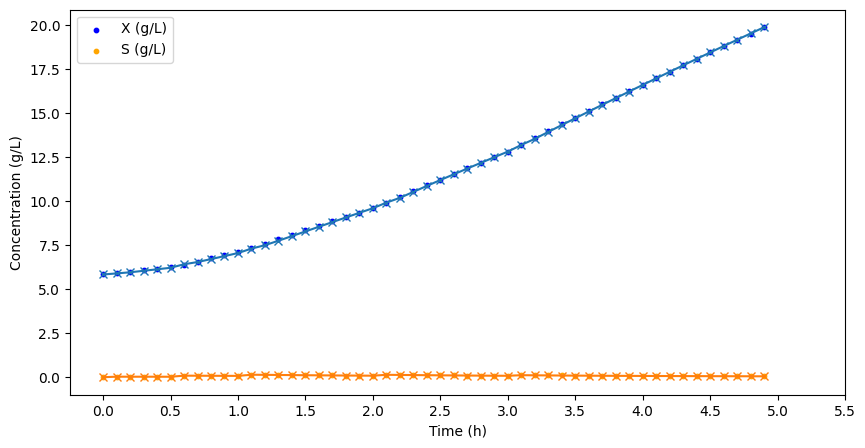

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(df['Time'], df['X'], label='X (g/L)', color='blue', s=10)
plt.scatter(df['Time'], df['S'], label='S (g/L)', color='orange', s=10)

plt.plot(t_test.detach().cpu().numpy(), X_preds, marker='x', label="_X_pred")
plt.plot(t_test.detach().cpu().numpy(), S_preds, marker='x', label="_S_pred")
plt.ylabel("Concentration (g/L)")
plt.legend(loc="best") 

plt.xticks(np.arange(0, 6, 0.5))
plt.xlabel("Time (h)")
plt.show()